## Import Libraries / Setup

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Load data
df = pd.read_excel('/Users/n/Desktop/US Health Insurance Dataset.xlsx')

In [5]:
# Removing duplicate values
df.drop_duplicates(inplace=True)

#### Data Setup

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [8]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
# add in variables
df['obesity_status'] = df.bmi.apply(lambda x:'obese' if x >=30 else 'not obese')
df.smoker = df.smoker.map({'yes':1, 'no':0})
df['smoker_obesity_status'] = ((df.smoker == 1) & (df.obesity_status == 'obese')).astype(int)
df['smoker_bmi_interaction'] = df.smoker * df.bmi

# adding smoking/bmi interaction term and obesity status as EDA shown both to be essential features in trends

In [10]:
# one-hot encoding data
categorical_columns = ['sex','smoker','region','obesity_status','smoker_obesity_status']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
# additional step because the one-hot encoding is giving out booleans instead of binary
boolean_columns = df_encoded.select_dtypes(include='bool').columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1337 non-null   int64  
 1   bmi                      1337 non-null   float64
 2   children                 1337 non-null   int64  
 3   charges                  1337 non-null   float64
 4   smoker_bmi_interaction   1337 non-null   float64
 5   sex_male                 1337 non-null   int64  
 6   smoker_1                 1337 non-null   int64  
 7   region_northwest         1337 non-null   int64  
 8   region_southeast         1337 non-null   int64  
 9   region_southwest         1337 non-null   int64  
 10  obesity_status_obese     1337 non-null   int64  
 11  smoker_obesity_status_1  1337 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 135.8 KB


## Recursive Feature Elimination 

In [12]:
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### RFE

#### MSE vs. Number of Features

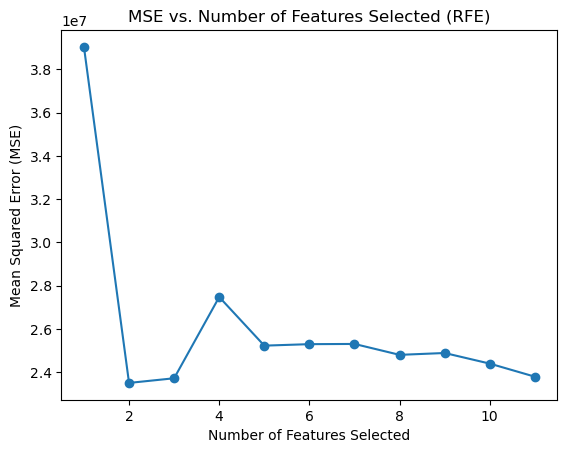

In [15]:
# Comparing MSE with number of features for feature selection 

model = RandomForestRegressor(n_estimators=100, random_state=42)

mse_values = []
num_features = []

for num in range(1, X.shape[1] + 1): 
    rfe = RFE(estimator=model, n_features_to_select=num)
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    num_features.append(num)

plt.plot(num_features, mse_values, marker='o')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Number of Features Selected (RFE)')
plt.show()

# 3-4 features seem to be most ideal

#### Random Forest Regressor Model

In [17]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=3)

rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe, y_train)

y_pred = model.predict(X_test_rfe)
mse = mean_squared_error(y_test, y_pred)

# Baseline MSE
baseline_pred = [y_test.mean()] * len(y_test)  # Predicting the mean for all instances
baseline_mse = mean_squared_error(y_test, baseline_pred)
print(f"Baseline MSE: {baseline_mse:.2f}")


# Mean Squared Error / Feature Importance
print(f"Model MSE: {mse:.2f}")
print()
print("Feature importances for selected features:", model.feature_importances_)

# Mean / SD of Target Values
print()
print("Mean of target values:", y_test.mean())
print("Standard deviation of target values:", y_test.std())

#print("All features:", X.columns)
#print("Feature ranking:", rfe.ranking_)
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

# Baseline MSE: 171,117,708.13

# Age, smoker_bmi_interaction, smoker_obesity_status_1: 23728930
# Without added interaction terms 
# Age, smoker_obesity_status, smoker_bmi_interaction MSE: 27172743

# Adding interaction term and obesity feature decreased the MSE

Baseline MSE: 171117708.13
Model MSE: 23728930.37

Feature importances for selected features: [0.13883091 0.73683913 0.12432996]

Mean of target values: 13846.763465743781
Standard deviation of target values: 13097.497302211796
Selected features: Index(['age', 'smoker_bmi_interaction', 'smoker_obesity_status_1'], dtype='object')


In [18]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = np.mean(np.abs(cv_scores))
print(f"Cross-validated Mean Squared Error (MSE): {mean_cv_score:.2f}")

Cross-validated Mean Squared Error (MSE): 24122176.49


### RFECV

Optimal number of features: 11
Selected Features: Index(['age', 'bmi', 'children', 'smoker_bmi_interaction', 'sex_male',
       'smoker_1', 'region_northwest', 'region_southeast', 'region_southwest',
       'obesity_status_obese', 'smoker_obesity_status_1'],
      dtype='object')


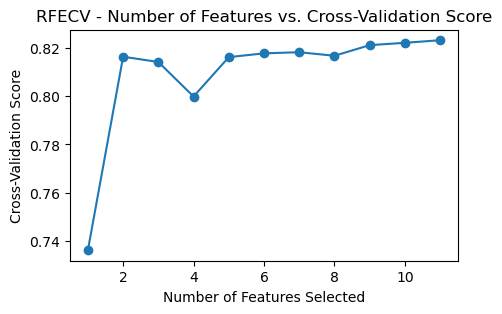

Mean Squared Error: 23864322.5275409


In [20]:
model = RandomForestRegressor()
rfecv = RFECV(estimator=model, step=1, cv=5)
rfecv.fit(X_train, y_train)

print("Optimal number of features:", rfecv.n_features_)
selected_features = X.columns[rfecv.support_]
print("Selected Features:", selected_features)

mean_cv_scores = rfecv.cv_results_['mean_test_score'] 

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(mean_cv_scores) + 1), mean_cv_scores, marker='o')
plt.title('RFECV - Number of Features vs. Cross-Validation Score')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Score')
plt.show()

y_pred = rfecv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [21]:
# Feature importance for the selected features
importances = rfecv.estimator_.feature_importances_

print(f"Number of features selected: {len(rfecv.support_)}")
print(f"Number of columns in X: {len(X.columns)}")

selected_features = X.columns[rfecv.support_]
feature_importance = dict(zip(selected_features, importances))

print("Feature Importance:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.4f}")

#These variables had greatest feature importance:
#age: 0.1370
#bmi: 0.0672
#smoker_bmi_interaction: 0.6440
#smoker_obesity_status_1: 0.0875

Number of features selected: 11
Number of columns in X: 11
Feature Importance:
age: 0.1347
bmi: 0.0601
children: 0.0213
smoker_bmi_interaction: 0.6763
sex_male: 0.0071
smoker_1: 0.0083
region_northwest: 0.0061
region_southeast: 0.0059
region_southwest: 0.0038
obesity_status_obese: 0.0168
smoker_obesity_status_1: 0.0596


## GridSearch

In [23]:
X_relevant = df_encoded[['age','bmi','smoker_bmi_interaction','smoker_obesity_status_1']]
X_train, X_test, y_train, y_test = train_test_split(X_relevant, y, test_size=0.3, random_state=42)

In [24]:
# Grid search for optimal hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

#Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
#Best Cross-Validation Score: 0.8426709956522398

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/Users/n/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
255 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/n/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/n/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/n/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/n/anaconda3/

## Model Performance

In [26]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2: {r2}")

Mean Squared Error: 23102335.639266882
R2: 0.864991555276386
